In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import pandas as pd
from typing import List, Optional, Tuple
from tqdm import tqdm
from torch.utils.data import Dataset

from utils import (
    CellDataset,
    extract_cells_from_xml,
    extract_patch_from_h5,
    extract_img_from_h5,
    create_mask_from_xml,
    create_df,
    extract_cells_from_xml_voxel,
    get_keypoints_from_heatmap_batch_maxpool_3d,
    match_keypoints_3d,
    calculate_precision_recall_curve,
    calculate_precision_recall_f1_at_threshold,
    calculate_average_precision,
)
from unet3d.models import ResidualUNet3D

/cis/home/zfang23/miniconda3/envs/cell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SPLIT = "test"

In [3]:
h5_path = "data/A4_6mo_no_dextran_long_one/A4_wt_pdcre_rce_6mo_nod_R2_ma.h5.h5"
img = extract_img_from_h5(h5_path, resolution=2)
img = img.astype(np.float32)
img.shape

(28, 168, 247, 251)

In [4]:
xml_path = "data/A4_6mo_no_dextran_long_one/A4_wt_pdcre_rce_6mo_nod_R2_ma-mamut.xml"
mask = create_mask_from_xml(xml_path, img.shape)

cells = extract_cells_from_xml_voxel(xml_path)

voxel size [2.         1.68000027 1.68000027]
voxel size [2.         1.68000027 1.68000027]


In [5]:
df = pd.DataFrame([{"t": i} for i in range(28)])
splits = []
for i in range(len(df)):
    if df.loc[i, "t"] < 14:
        split = "train"
    elif df.loc[i, "t"] < 21:
        split = "val"
    else:
        split = "test"
    splits.append(split)
df["split"] = splits

df

,t,split
0,0,train
1,1,train
2,2,train
3,3,train
4,4,train
5,5,train
6,6,train
7,7,train
8,8,train
9,9,train


In [6]:
class CellDatasetWhole(Dataset):
    def __init__(self, image, mask, cells, df, split):
        self.image = image
        self.mask = mask
        self.cells = cells
        self.df = df

        self.df = self.df[self.df["split"] == split]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        t = sample["t"]

        # extract image
        img = self.image[t]
        label = self.mask[t]

        # extract cells in the patch
        cells = np.ones((1000, 3), dtype=int) * -1
        k = 0
        for cell in self.cells:
            if cell["t"] == t:
                cells[k] = [cell["z"], cell["y"], cell["x"]]
                k += 1

        meta = {"cells": cells, "t": t}

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        # return dict of
        return img, label, meta

In [7]:
img_pad = np.pad(img, ((0, 0), (0, 8), (0, 9), (0, 5)), mode="constant")
print(img.shape)
mask_pad = np.pad(mask, ((0, 0), (0, 8), (0, 9), (0, 5)), mode="constant")

dataset = CellDatasetWhole(img_pad, mask_pad, cells, df, SPLIT)
len(dataset)

(28, 168, 247, 251)


7

In [8]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

checkpoint_path = "checkpoint.pth"
device = "cuda"

model = ResidualUNet3D(in_channels=1, out_channels=1)
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [9]:
input_, label, meta = dataset[5]
input_ = input_.unsqueeze(0).to(device)
label = label.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_)
output = F.sigmoid(output)

input_np = input_.detach().cpu().numpy()
label_np = label.detach().cpu().numpy()
output_np = output.detach().cpu().numpy()
print(input_np.shape)

(1, 1, 176, 256, 256)


In [10]:
gt_coors = np.array(meta["cells"])
gt_coors = gt_coors[gt_coors[:, 0] != -1]
print(gt_coors.shape)

(166, 3)


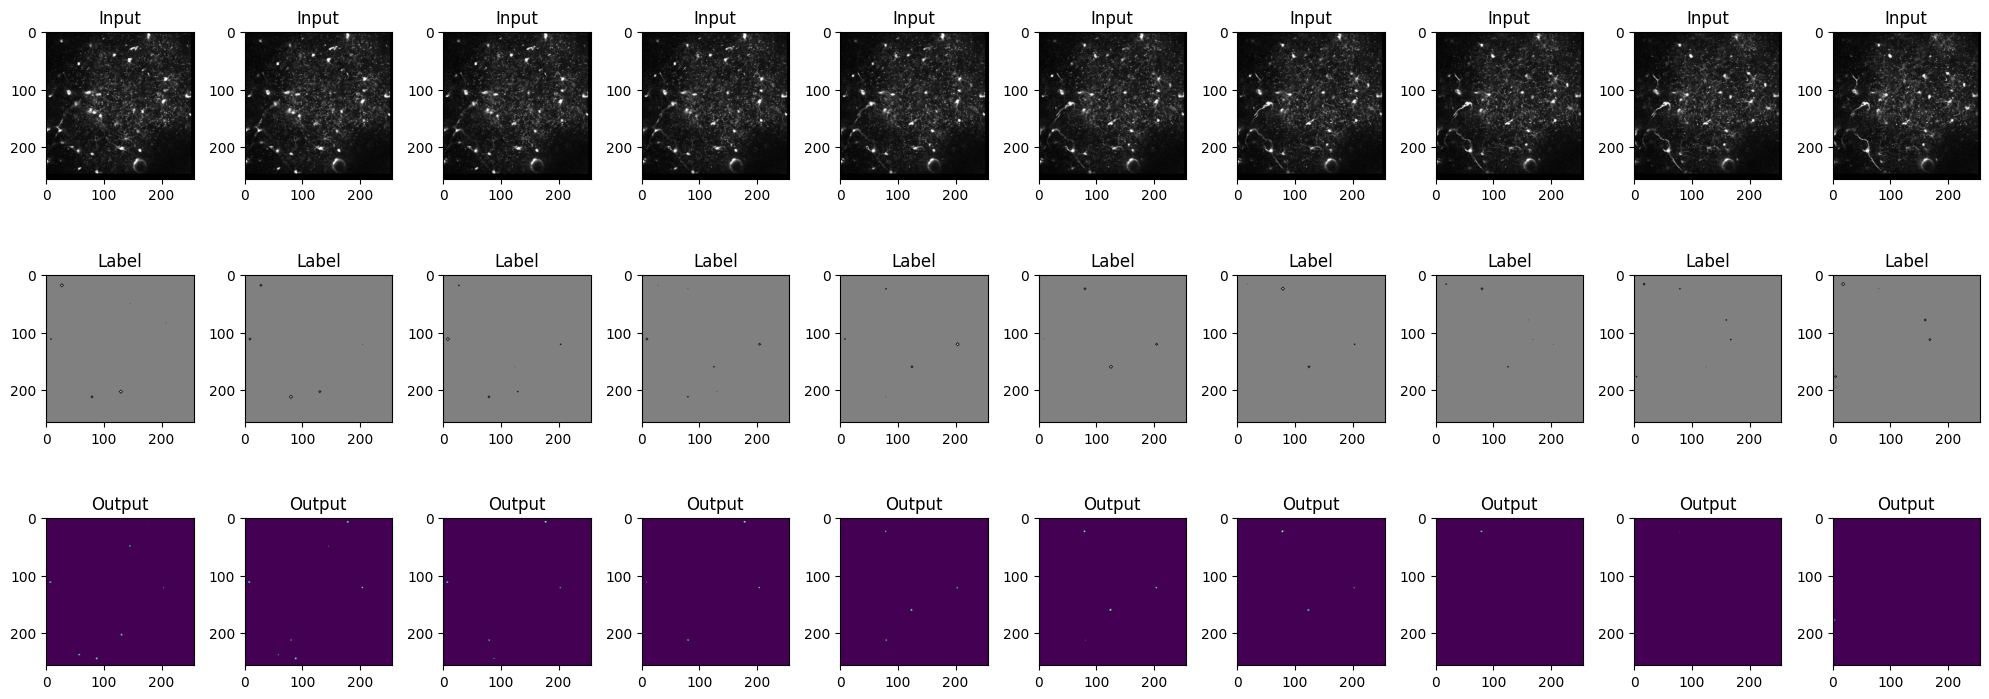

In [11]:
fig, axes = plt.subplots(3, 10, figsize=(20, 8), layout="tight")
z = 100
for i in range(10):
    axes[0, i].imshow(input_np[0, 0, z + i], cmap="gray")
    axes[0, i].set_title("Input")
    axes[1, i].imshow(label_np[0, 0, z + i], cmap="gray", vmin=-1, vmax=1)
    axes[1, i].set_title("Label")
    axes[2, i].imshow(output_np[0, 0, z + i], vmin=0, vmax=1)
    axes[2, i].set_title("Output")

In [12]:
filtered_coors, filtered_scores = get_keypoints_from_heatmap_batch_maxpool_3d(
    output, max_keypoints=200, min_keypoint_pixel_distance=3, abs_max_threshold=0.5
)

coors = np.array(filtered_coors[0][0])
scores = np.array(filtered_scores[0][0])
coors.shape, scores.shape

/cis/home/zfang23/miniconda3/envs/cell/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/cis/home/zfang23/miniconda3/envs/cell/lib/python3.12/site-packages/torch/nn/modules/conv.py:594: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


((169, 3), (169,))

In [13]:
scores

array([0.9936327 , 0.99344003, 0.9923531 , 0.99122363, 0.99009806,
       0.99006253, 0.9858653 , 0.9844096 , 0.9837218 , 0.9837068 ,
       0.9836875 , 0.9836213 , 0.98352796, 0.9832466 , 0.9830838 ,
       0.9827168 , 0.9824755 , 0.98235214, 0.98227674, 0.9822478 ,
       0.98121357, 0.98106825, 0.9790355 , 0.97676474, 0.97653955,
       0.9758651 , 0.975834  , 0.97547495, 0.97479284, 0.97479224,
       0.9747752 , 0.9746147 , 0.9745057 , 0.97391105, 0.9738961 ,
       0.9734012 , 0.97332865, 0.9732884 , 0.97260356, 0.9719781 ,
       0.97114146, 0.97017777, 0.9697446 , 0.96897143, 0.9681961 ,
       0.96804106, 0.9670656 , 0.96692383, 0.96690285, 0.9668229 ,
       0.9666279 , 0.96608585, 0.9659491 , 0.96591806, 0.9658844 ,
       0.96574   , 0.96569645, 0.96559703, 0.9655687 , 0.9647022 ,
       0.964612  , 0.9645121 , 0.96429276, 0.96426034, 0.96355367,
       0.9616438 , 0.9611732 , 0.9603032 , 0.9598883 , 0.9598463 ,
       0.9588081 , 0.9583304 , 0.958304  , 0.9582503 , 0.95806

In [14]:
# plot the keypoints
def plot_keypoints_3d(ax, coors, z):
    for coor in coors:
        if coor[0] == z:
            ax.scatter(
                coor[2],
                coor[1],
                s=300,
                alpha=0.9,
                facecolors="none",
                edgecolors="r",
                linewidths=4,
            )
        elif np.abs(coor[0] - (z)) < 3:
            ax.scatter(
                coor[2],
                coor[1],
                s=300,
                alpha=0.9,
                facecolors="none",
                edgecolors="r",
                linewidths=2,
                linestyle="--",
            )


# fig, axes = plt.subplots(4, 5, figsize=(20, 15), layout="tight")
# z = 160
# for i in range(5):
#     axes[0, i].imshow(input_np[0, 0, z + i], cmap="gray")
#     axes[0, i].set_title("Input")
#     axes[1, i].imshow(input_np[0, 0, z + i], cmap="gray", vmin=0, vmax=255)
#     plot_keypoints_3d(axes[1, i], gt_coors, z + i)
#     axes[1, i].set_title("Label")
#     axes[2, i].imshow(input_np[0, 0, z + i], cmap="gray")
#     plot_keypoints_3d(axes[2, i], coors, z + i)
#     axes[2, i].set_title("Detected keypoints")
#     axes[3, i].imshow(output_np[0, 0, z + i], vmin=0, vmax=1)
#     axes[3, i].set_title("Output heatmap")

In [15]:
def evaluate(dataloader, model):
    model.eval()
    pred_keypoints = []
    gt_keypoints = set()
    for i, (inputs, labels, metas) in enumerate(tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        outputs = F.sigmoid(outputs)

        filtered_coors, filtered_scores = get_keypoints_from_heatmap_batch_maxpool_3d(
            outputs,
            max_keypoints=300,
            min_keypoint_pixel_distance=3,
            abs_max_threshold=0.01,
        )

        for b in range(len(inputs)):
            coors = np.array(filtered_coors[b][0])
            scores = np.array(filtered_scores[b][0])
            gt_coors = np.array(metas["cells"][b])
            gt_coors = gt_coors[gt_coors[:, 0] != -1]

            matches = match_keypoints_3d(coors, gt_coors, pixel_distance_threshold=5)

            img_id = metas["t"][b].item()
            for i in range(len(coors)):
                pred_keypoint = {
                    "img_id": img_id,
                    "coor": tuple(coors[i]),
                    "score": scores[i],
                    "matched": [(img_id, tuple(gt_coors[idx])) for idx in matches[i]],
                }
                pred_keypoints.append(pred_keypoint)

            for gt_coor in gt_coors:
                gt_keypoints.add((img_id, tuple(gt_coor)))

    return pred_keypoints, sorted(gt_keypoints)


pred_keypoints, gt_keypoints = evaluate(loader, model)

100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


In [16]:
pred_keypoints[400]

{'img_id': 23,
 'coor': (50, 123, 36),
 'score': 0.9595138,
 'matched': [(23, (50, 123, 36))]}

In [17]:
gt_keypoints[1000]

(27, (22, 234, 87))

In [18]:
len(pred_keypoints), len(gt_keypoints)

(1123, 1145)

## Numerial Results

In [19]:
prec, rec = calculate_precision_recall_curve(pred_keypoints, len(gt_keypoints))

ap = calculate_average_precision(prec, rec)

(0.0, 1.0)

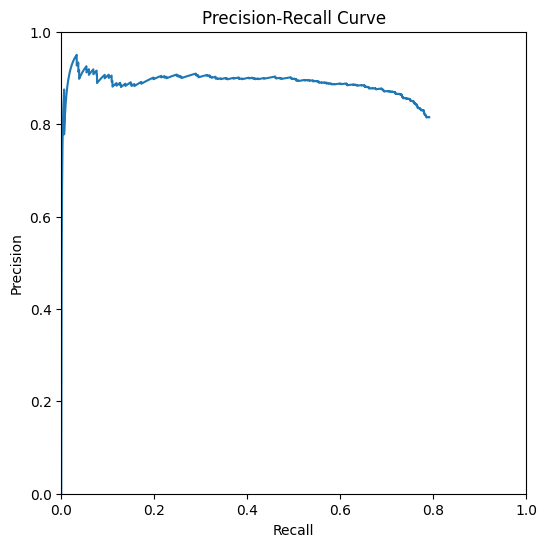

In [20]:
# plot precision-recall curve
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(rec, prec)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

In [21]:
prec, rec, f1 = calculate_precision_recall_f1_at_threshold(
    pred_keypoints, len(gt_keypoints), 0.5
)

print("Average precision:", ap)

print(f"At threshold 0.5: Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

Average precision: 0.7042055985006923
At threshold 0.5: Precision: 0.8290, Recall: 0.7799, F1: 0.8037


## Visualization

In [22]:
import imageio
from matplotlib.lines import Line2D

In [23]:
img_id = 21

pred_coors = [kp["coor"] for kp in pred_keypoints if kp["img_id"] == img_id]
gt_coors = [kp[1] for kp in gt_keypoints if kp[0] == img_id]

pred_coors = np.array(pred_coors)
gt_coors = np.array(gt_coors)
pred_coors.shape, gt_coors.shape

((158, 3), (164, 3))

In [24]:
img_pad.shape

(28, 176, 256, 256)

In [25]:
img_pad.max(), img_pad.min()

(255.0, 0.0)

In [26]:
def make_video(pred_coors, gt_coors):
    img = img_pad

    images = []
    for i in range(0, img.shape[1]):
        fig, ax = plt.subplots(figsize=(6, 6))#, layout="tight")
        ax.imshow(img[img_id, i], cmap="gray", vmin=0, vmax=255)

        def _plot(ax, coors, color):
            d = 4
            for coor in coors:
                if abs(coor[0] - i) <= d:
                    ratio = 1 - abs(coor[0] - i) / d
                    s = 300 * ratio
                    ax.scatter(
                        coor[2],
                        coor[1],
                        s=s,
                        alpha=0.8,
                        facecolors="none",
                        edgecolors=color,
                        linewidths=1.5,
                        linestyle="-",
                    )

        _plot(ax, gt_coors, "r")
        _plot(ax, pred_coors, "lime")
        ax.set_title(f"Slice {i}")
        ax.axis("off")
        

        legend_elements = [
            Line2D(
                [0],
                [0],
                marker="o",
                color="none",
                label="GT",
                markeredgecolor="r",
                markersize=10,
            ),
            Line2D(
                [0],
                [0],
                marker="o",
                color="none",
                label="Pred",
                markeredgecolor="lime",
                markersize=10,
            ),
        ]

        # Create the figure
        ax.legend(handles=legend_elements, loc="upper right")
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close(fig)

    imageio.mimsave("result.mov", images, fps=3)
    imageio.mimsave("result.gif", images, fps=3)


# test
make_video(pred_coors, gt_coors)

/tmp/ipykernel_777727/3420930504.py:56: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x626db40] Warning: data is not aligned! This can lead to a speed loss
